In [ ]:
import sys
from pathlib import Path
src_path = Path.cwd().parent / 'src'
sys.path.append(str(src_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [ ]:
from data_loader import load_data

# Set up data paths
data_path = Path.cwd().parent / "data" / "ag_news"
train_path = data_path / "train.csv"
test_path = data_path / "test.csv"

# Load training data
df_train = load_data(train_path)
X_train = (df_train["Title"] + " " + df_train["Description"]).values
y_train = df_train["Class Index"].values

# Load test data
df_test = load_data(test_path)
X_test = (df_test["Title"] + " " + df_test["Description"]).values
y_test = df_test["Class Index"].values

# Show training data
# df_train.head()

# Show test data
# df_test.head()


In [ ]:
from vectorizer import vectorize_data_fit
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize data
vectorizer = TfidfVectorizer()
X_train_vect = vectorize_data_fit(vectorizer, X_train)

In [ ]:
from model_trainer import train_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression Model
lg_model = LogisticRegression()
#lg_trained_model = train_model(lg_model, X_train_vect, y_train)

# Train Naive Bayes Model
nb_model = MultinomialNB()
nb_trained_model = train_model(nb_model, X_train_vect, y_train)

# Train Random Forest Model
rf_model = RandomForestClassifier()
#rf_trained_model = train_model(rf_model, X_train_vect, y_train)

In [ ]:
# from perturbation import apply_perturbation

# # Save perturbed data to file

# X_data = X_test[:1000]
# level = 1.0

# perturbed_data = apply_perturbation(
#     X_data,
#     level,
#     save_path=f"perturbed_data/deletion/perturbed_data_{level:.2f}.pkl"
# )



In [ ]:
from evaluator import evaluate_robustness

# Evaluation pipeline

# Number of samples to evaluate
X_sample = X_test[:1000]
y_sample = y_test[:1000]

# Define perturbation levels to test
perturbation_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Add required metrics to evaluate
metrics = ["base_accuracy", "robustness_score", "effective_robustness", "mce", "pdr", "our_metric"]

# Use filepath when using pertrubed data from files for faster testing
file_path = Path("perturbed_data/charswap")

# Add model to evaluate (also used for plotting)
model = nb_trained_model

results, metrics_summary = evaluate_robustness(
    model,
    vectorizer,
    X_sample, 
    y_sample,
    perturbation_levels,
    metrics,
    file_path
)

# Do we need metric summary? - info given in table for each level instead
# print("*** Metrics Summary ***")
# for metric, value in metrics_summary.items():
#     print(f"{metric}: {value: .4f}")

results_df = pd.DataFrame(results)
print("*** Results Per Perturbation Level")
display(results_df)

# Save results for each model
# LR
#results_df.to_csv(Path("results/wordnet/lr.csv"), index=False)
# NB
#results_df.to_csv(Path("results/charswap/nb.csv"), index=False)
# RF
#results_df.to_csv(Path("results/deletion/rf.csv"), index=False)


PLOTTING RESULTS

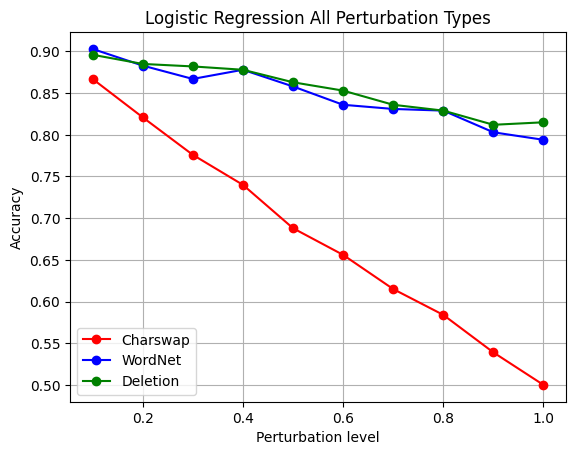

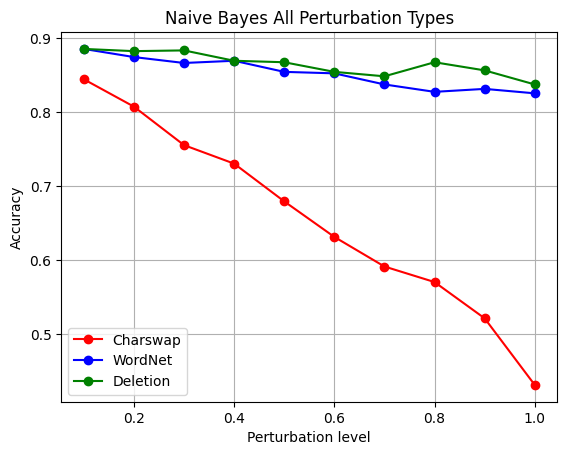

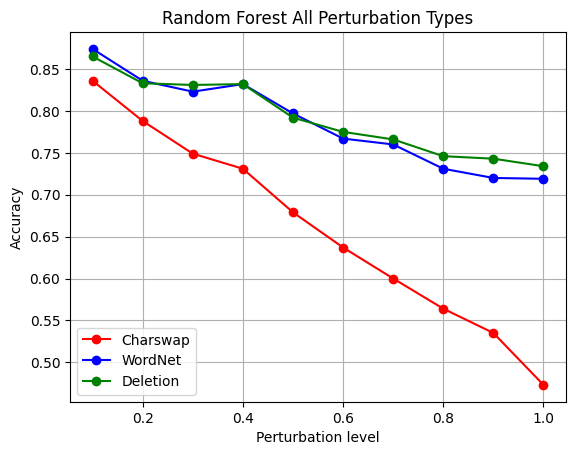

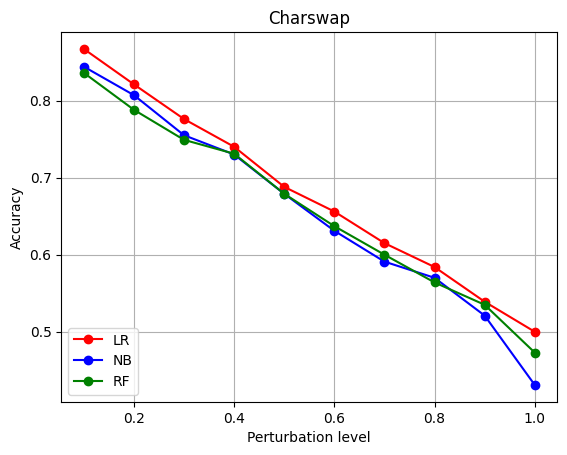

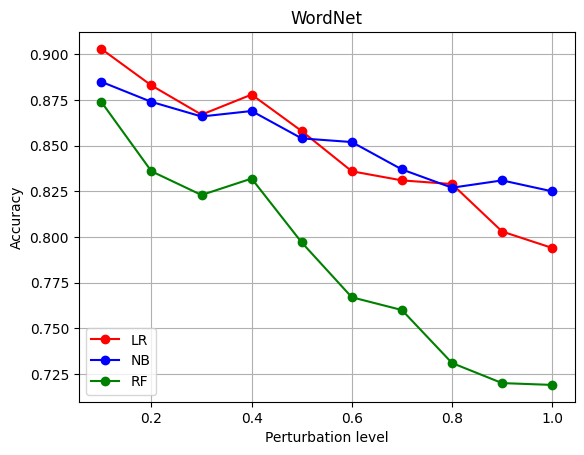

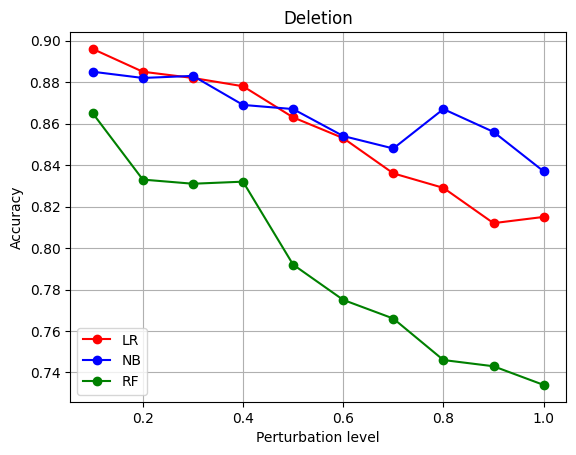

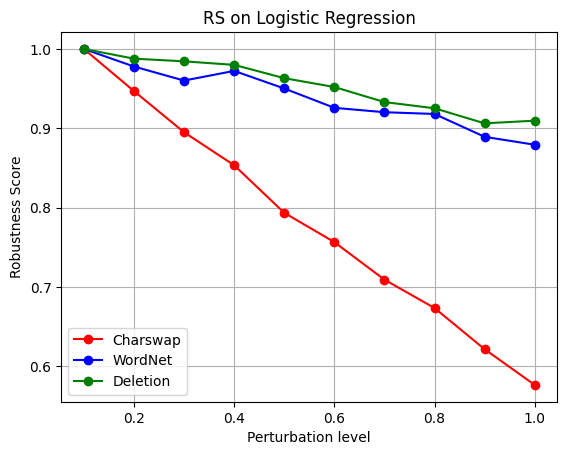

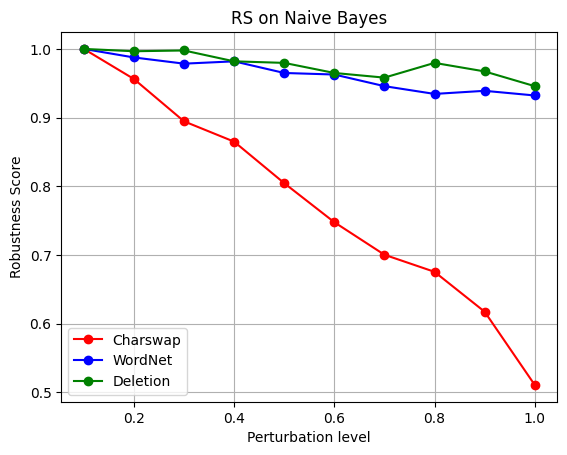

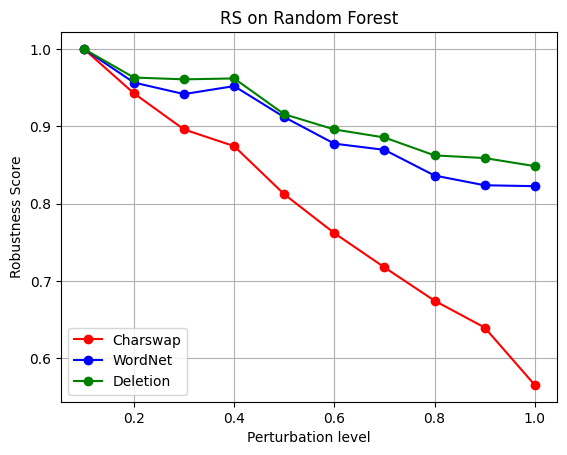

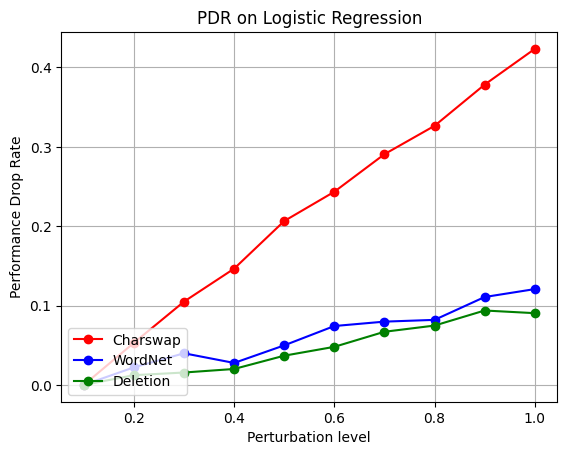

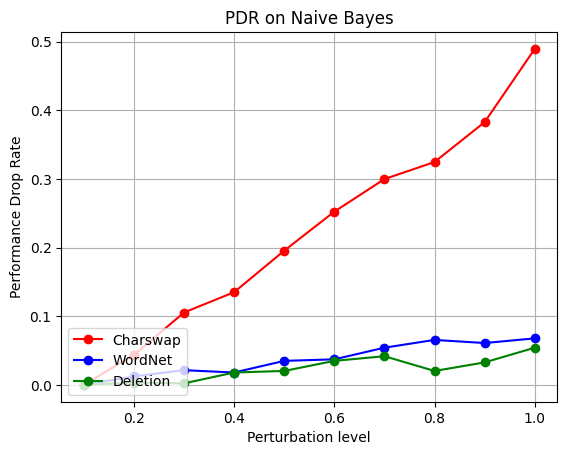

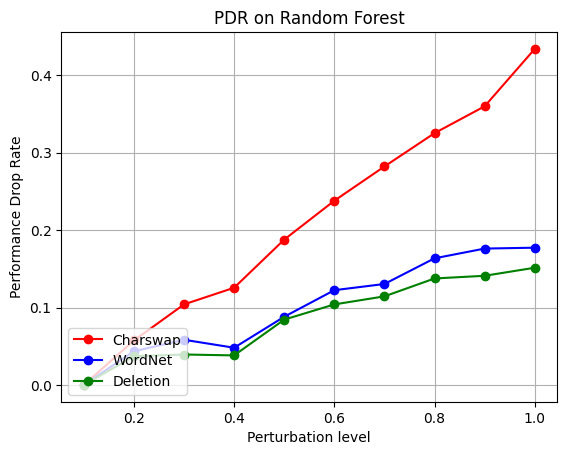

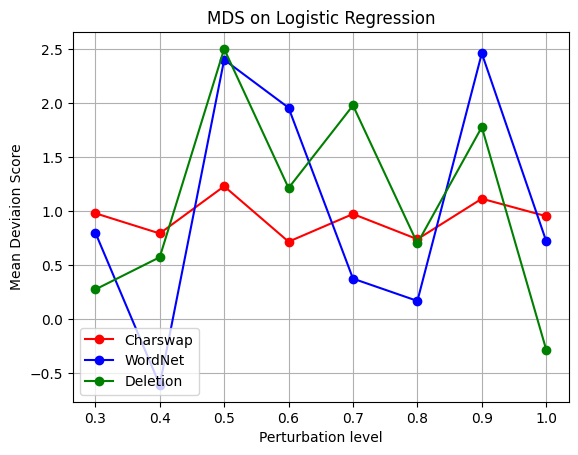

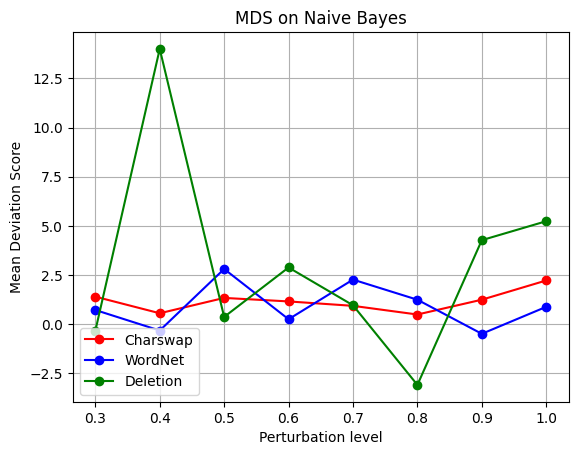

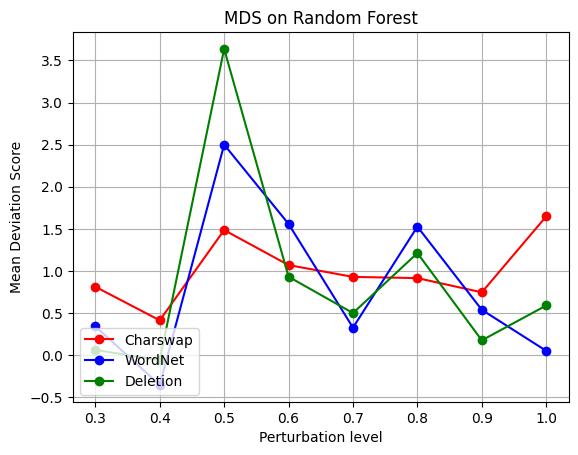

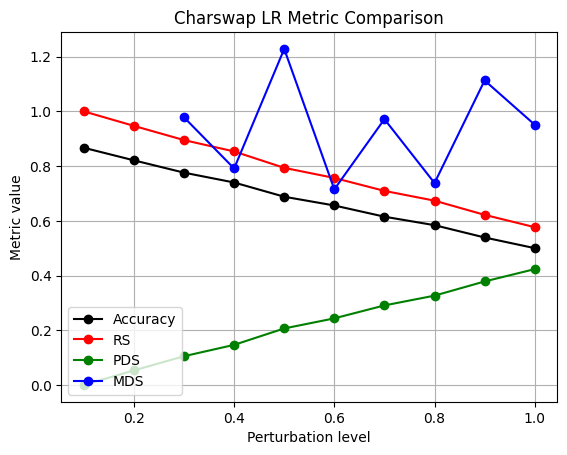

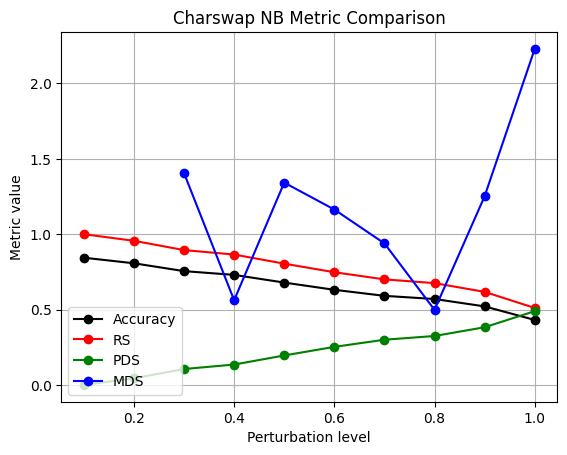

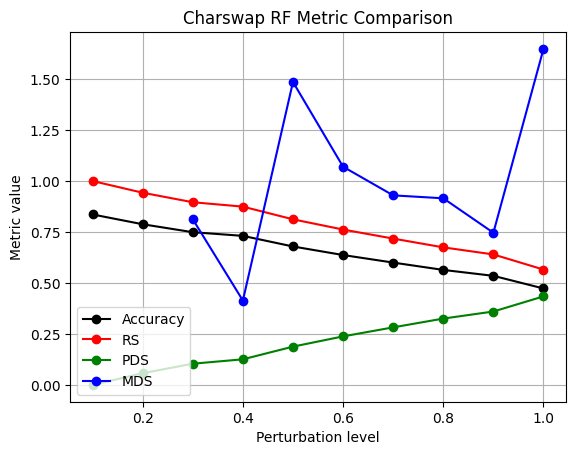

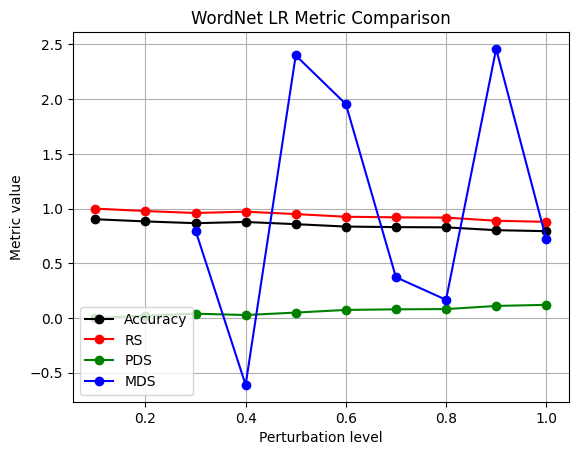

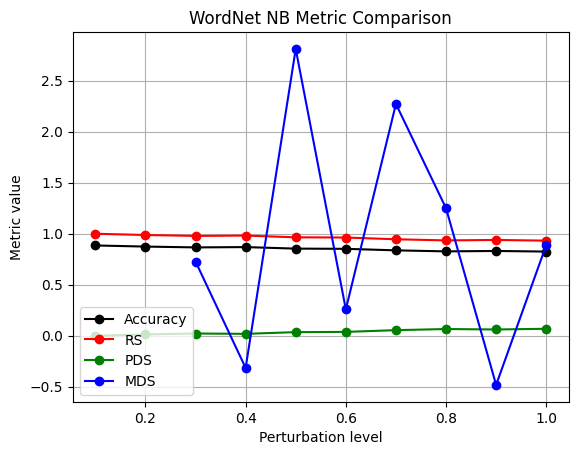

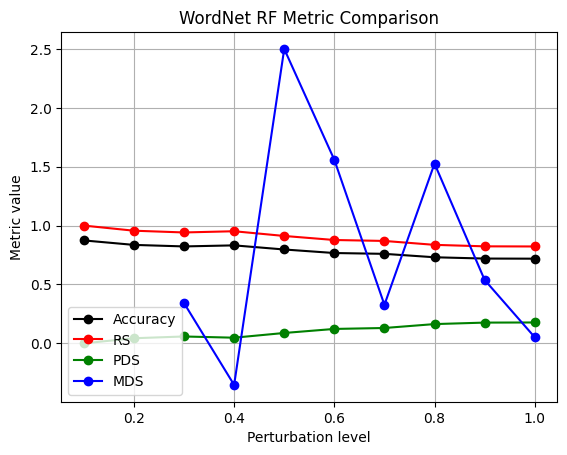

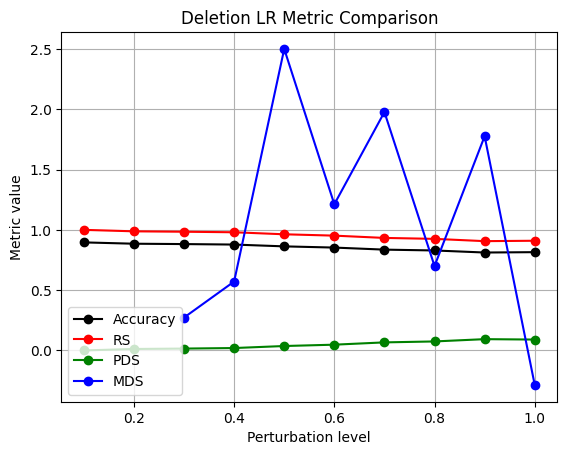

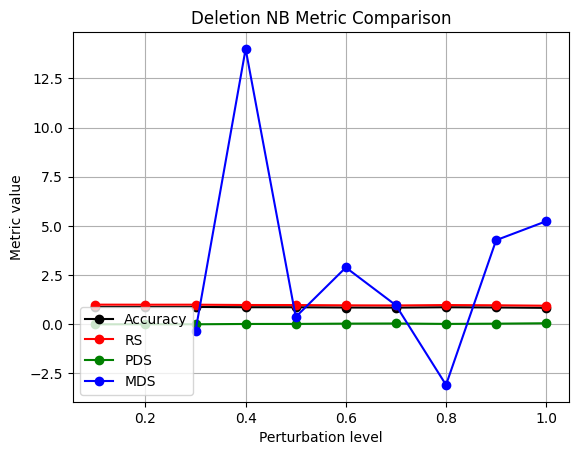

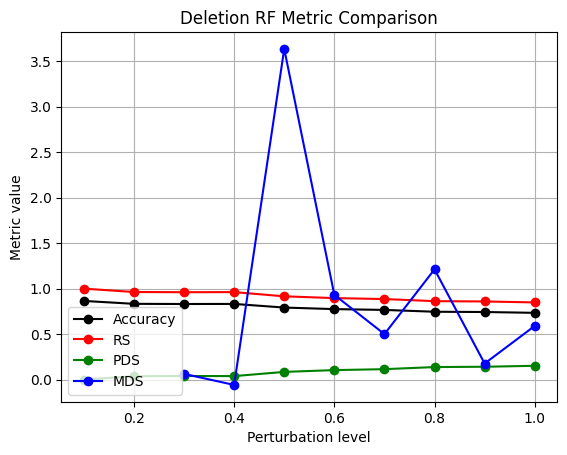

In [38]:
# load csv files

#CHARSWAP
df_chars_lr = pd.read_csv(Path("results/charswap/lr.csv"))
df_chars_nb = pd.read_csv(Path("results/charswap/nb.csv"))
df_chars_rf = pd.read_csv(Path("results/charswap/rf.csv"))

#DELETION
df_del_lr = pd.read_csv(Path("results/deletion/lr.csv"))
df_del_nb = pd.read_csv(Path("results/deletion/nb.csv"))
df_del_rf = pd.read_csv(Path("results/deletion/rf.csv"))

#WORDNET
df_word_lr = pd.read_csv(Path("results/wordnet/lr.csv"))
df_word_nb = pd.read_csv(Path("results/wordnet/nb.csv"))
df_word_rf = pd.read_csv(Path("results/wordnet/rf.csv"))


# SUBSETS TO PLOT

# LR all accuracy/perturbation
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["accuracy"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["accuracy"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["accuracy"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Logistic Regression All Perturbation Types")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# NB all accuracy/perturbation
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["accuracy"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["accuracy"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["accuracy"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Naive Bayes All Perturbation Types")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# RF all
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["accuracy"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["accuracy"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["accuracy"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Random Forest All Perturbation Types")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# CHARSWAP
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["accuracy"], marker="o", linestyle= "-", color="red", label="LR")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["accuracy"], marker="o", linestyle= "-", color="blue", label="NB")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["accuracy"], marker="o", linestyle= "-", color="green", label="RF")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Charswap")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# WORDNET
plt.plot(df_word_lr["perturbation level"], df_word_lr["accuracy"], marker="o", linestyle= "-", color="red", label="LR")
plt.plot(df_word_nb["perturbation level"], df_word_nb["accuracy"], marker="o", linestyle= "-", color="blue", label="NB")
plt.plot(df_word_rf["perturbation level"], df_word_rf["accuracy"], marker="o", linestyle= "-", color="green", label="RF")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("WordNet")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# DELETION
plt.plot(df_del_lr["perturbation level"], df_del_lr["accuracy"], marker="o", linestyle= "-", color="red", label="LR")
plt.plot(df_del_nb["perturbation level"], df_del_nb["accuracy"], marker="o", linestyle= "-", color="blue", label="NB")
plt.plot(df_del_rf["perturbation level"], df_del_rf["accuracy"], marker="o", linestyle= "-", color="green", label="RF")
plt.xlabel("Perturbation level")
plt.ylabel("Accuracy")
plt.title("Deletion")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# METRICS
# ROBUSTNESS SCORE ALL LR
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["RS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["RS"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["RS"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Robustness Score")
plt.title("RS on Logistic Regression")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# ROBUSTNESS SCORE ALL NB
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["RS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["RS"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["RS"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Robustness Score")
plt.title("RS on Naive Bayes")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# ROBUSTNESS SCORE ALL RF
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["RS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["RS"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["RS"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Robustness Score")
plt.title("RS on Random Forest")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# PDR ALL LR
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["PDR"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["PDR"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["PDR"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Performance Drop Rate")
plt.title("PDR on Logistic Regression")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# PDR ALL NB
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["PDR"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["PDR"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["PDR"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Performance Drop Rate")
plt.title("PDR on Naive Bayes")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# PDR ALL RF
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["PDR"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["PDR"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["PDR"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Performance Drop Rate")
plt.title("PDR on Random Forest")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# MDS ALL LR
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["MDS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_lr["perturbation level"], df_word_lr["MDS"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_lr["perturbation level"], df_del_lr["MDS"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Mean Deviaion Score")
plt.title("MDS on Logistic Regression")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# MDS ALL NB
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["MDS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_nb["perturbation level"], df_word_nb["MDS"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_nb["perturbation level"], df_del_nb["MDS"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Mean Deviation Score")
plt.title("MDS on Naive Bayes")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# MDS ALL RF
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["MDS"], marker="o", linestyle= "-", color="red", label="Charswap")
plt.plot(df_word_rf["perturbation level"], df_word_rf["MDS"], marker="o", linestyle= "-", color="blue", label="WordNet")
plt.plot(df_del_rf["perturbation level"], df_del_rf["MDS"], marker="o", linestyle= "-", color="green", label="Deletion")
plt.xlabel("Perturbation level")
plt.ylabel("Mean Deviation Score")
plt.title("MDS on Random Forest")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# METRICS ON EACH PERTURBATION TYPE COMPARED TO ACCURACY FOR EACH MODEL
# CHARSWAP LOGISTIC REGRESSION
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_chars_lr["perturbation level"], df_chars_lr["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Charswap LR Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# CHARSWAP NAIVE BAYES
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_chars_nb["perturbation level"], df_chars_nb["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Charswap NB Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# CHARSWAP RANDOM FOREST
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_chars_rf["perturbation level"], df_chars_rf["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Charswap RF Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()


# WORDNET LOGISTIC REGRESSION
plt.plot(df_word_lr["perturbation level"], df_word_lr["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_word_lr["perturbation level"], df_word_lr["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_word_lr["perturbation level"], df_word_lr["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_word_lr["perturbation level"], df_word_lr["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("WordNet LR Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# WORDNET NAIVE BAYES
plt.plot(df_word_nb["perturbation level"], df_word_nb["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_word_nb["perturbation level"], df_word_nb["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_word_nb["perturbation level"], df_word_nb["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_word_nb["perturbation level"], df_word_nb["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("WordNet NB Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# WORDNET RANDOM FOREST
plt.plot(df_word_rf["perturbation level"], df_word_rf["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_word_rf["perturbation level"], df_word_rf["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_word_rf["perturbation level"], df_word_rf["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_word_rf["perturbation level"], df_word_rf["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("WordNet RF Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# DELETION LOGISTIC REGRESSION
plt.plot(df_del_lr["perturbation level"], df_del_lr["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_del_lr["perturbation level"], df_del_lr["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_del_lr["perturbation level"], df_del_lr["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_del_lr["perturbation level"], df_del_lr["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Deletion LR Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# DELETION NAIVE BAYES
plt.plot(df_del_nb["perturbation level"], df_del_nb["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_del_nb["perturbation level"], df_del_nb["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_del_nb["perturbation level"], df_del_nb["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_del_nb["perturbation level"], df_del_nb["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Deletion NB Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# DELETION RANDOM FOREST
plt.plot(df_del_rf["perturbation level"], df_del_rf["accuracy"], marker="o", linestyle= "-", color="black", label="Accuracy")
plt.plot(df_del_rf["perturbation level"], df_del_rf["RS"], marker="o", linestyle= "-", color="red", label="RS")
plt.plot(df_del_rf["perturbation level"], df_del_rf["PDR"], marker="o", linestyle= "-", color="green", label="PDS")
plt.plot(df_del_rf["perturbation level"], df_del_rf["MDS"], marker="o", linestyle= "-", color="blue", label="MDS")

plt.xlabel("Perturbation level")
plt.ylabel("Metric value")
plt.title("Deletion RF Metric Comparison")
plt.legend(loc="lower left")
plt.grid()
plt.show()